# Research list:
- Handling outliers in timeseries forecasting

In [289]:

import time

%matplotlib inline

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from functools import reduce

import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta, 
    RegressionEnsembleModel)               # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<

from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.utils.utils import ModelMode           # new 
from darts.utils.missing_values import fill_missing_values
from darts.utils.missing_values import missing_values_ratio

from darts.datasets import ( 
    AirPassengersDataset, AusBeerDataset, GasRateCO2Dataset, HeartRateDataset, 
    IceCreamHeaterDataset, MonthlyMilkDataset, SunspotsDataset)


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)



TRACE = False                 # print also the suboptimal models while SARIMA tuning process is running
MSEAS = 12                    # seasonality default
ALPHA = 0.1                  # significance level default

# Prepare the data

In [1]:
# Connect to snowflake
from snowflake.snowpark import Session
import json
credentials = json.load(open('secrets.json'))["SNOWFLAKE_CONNECTION"]

session = Session.builder.configs(credentials).create()

c:\Users\joebu\programming_directory\hackathon\venv\lib\site-packages\snowflake\connector\options.py:96: UserWarning: You have an incompatible version of 'pyarrow' installed (7.0.0), please install a version that adheres to: 'pyarrow<8.1.0,>=8.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [2]:
session.use_database("Covid19")
session.use_schema("public")
mdf = session.sql("""
                  SELECT
                  DATE
                  ,SUM(POSITIVE) as POSITIVE
                  FROM CDC_TESTING
                  GROUP BY DATE
                  """)

In [3]:
mdf = mdf.to_pandas()
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DATE      0 non-null      datetime64[ns]
 1   POSITIVE  0 non-null      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 124.0 bytes


In [115]:
mdf['DATE'] = pd.to_datetime(mdf['DATE'])
series = mdf
series.set_index(keys='DATE', inplace=True, drop=True)

In [116]:
series.describe()
series.head()
series = series.sort_index()

<AxesSubplot: xlabel='DATE'>

<Figure size 1200x500 with 0 Axes>

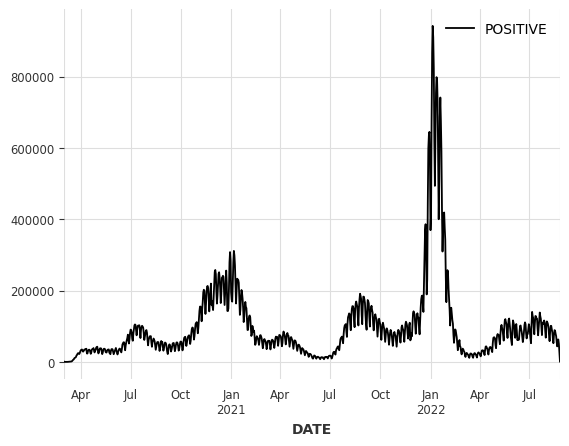

In [117]:
# plot the observations

plt.figure(100, figsize=(12, 5))
series.plot()

# Check for Outliers considering seasonality and trend

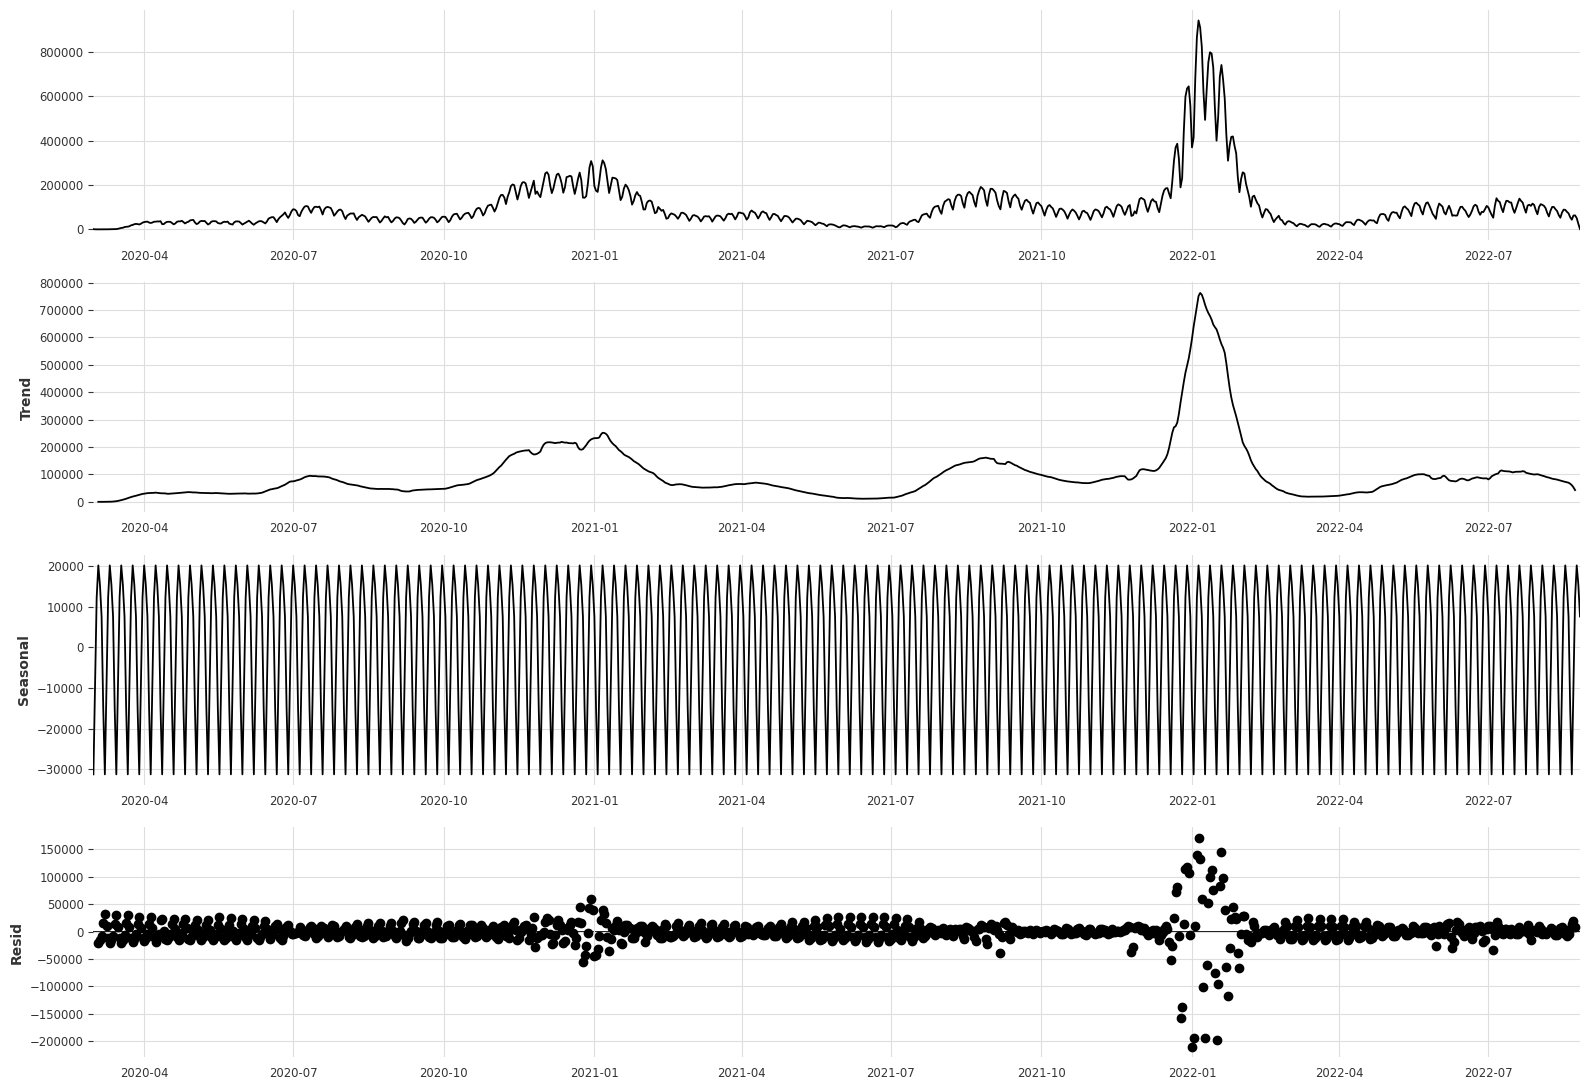

In [118]:
# Check for outliers despite seasonality and trend
#compute seasonal decomposition

from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(series, period=7)

#plot decomp
fig = decomp.plot()
fig.set_size_inches((16, 11))
fig.tight_layout()
plt.show()

In [119]:
#add decomp series to the df

series['trend'] = decomp.trend
series['seasonal'] = decomp.seasonal
series['resid'] = decomp.resid

In [120]:
#define 90% upper and lower bounds

z_val = 3
series['resid_UB'] = series['resid'].mean() + z_val * series['resid'].std()
series['resid_LB'] = series['resid'].mean() - z_val * series['resid'].std()

In [121]:
#add anomaly flags

series['is_anomaly'] = (np.where((series['resid'] > series['resid_UB'])
                             | (series['resid'] < series['resid_LB']),
                             1,0))

In [122]:
# display anomalies
display(series[series['is_anomaly'] == 1])

,POSITIVE,trend,seasonal,resid,resid_UB,resid_LB,is_anomaly
DATE,,,,,,,
2021-12-23,385997,288923.143,15367.805,81706.052,75916.134,-75867.688,1
2021-12-25,189286,362064.143,-14863.502,-157914.641,75916.134,-75867.688,1
2021-12-26,231390,400044.286,-31192.803,-137461.483,75916.134,-75867.688,1
2021-12-28,598071,471045.571,12247.792,114777.637,75916.134,-75867.688,1
2021-12-29,634917,496775.143,20120.175,118021.682,75916.134,-75867.688,1
2021-12-30,644804,522793.571,15367.805,106642.624,75916.134,-75867.688,1
2022-01-01,369393,594933.286,-14863.502,-210676.784,75916.134,-75867.688,1
2022-01-02,413519,638773.143,-31192.803,-194061.340,75916.134,-75867.688,1
2022-01-04,866109,714521.000,12247.792,139340.208,75916.134,-75867.688,1


In [246]:
# Drop the anamolies, and impute with darts
# series = series[series['is_anomaly'] != 1]
display(series.head())
ts_series = series['POSITIVE']
display(ts_series.index.value_counts())
series = series.dropna()
ts = TimeSeries.from_series(ts_series, fill_missing_dates=True, freq='D')
ts = fill_missing_values(ts, fill='auto')

,POSITIVE,trend,seasonal,resid,resid_UB,resid_LB,is_anomaly
DATE,,,,,,,
2020-03-01,1162,NaN,-31192.803,NaN,75916.134,-75867.688,0
2020-03-02,297,NaN,-9258.838,NaN,75916.134,-75867.688,0
2020-03-03,69,NaN,12247.792,NaN,75916.134,-75867.688,0
2020-03-04,131,300.429,20120.175,-20289.603,75916.134,-75867.688,0
2020-03-05,116,169.571,15367.805,-15421.376,75916.134,-75867.688,0


2020-03-01    1
2021-11-16    1
2021-10-21    1
2021-10-22    1
2021-10-23    1
             ..
2021-01-02    1
2021-01-03    1
2021-01-04    1
2021-01-05    1
2022-08-26    1
Name: DATE, Length: 909, dtype: int64

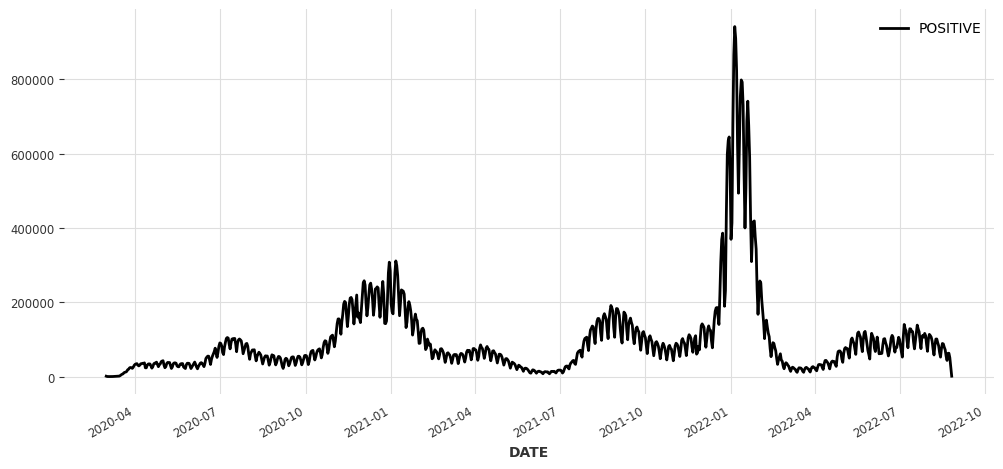

In [247]:
# Plot the new time series
plt.figure(100, figsize=(12, 5))
ts.plot()

# Plot and check ACF

p-value:  6.901275505136676e-12


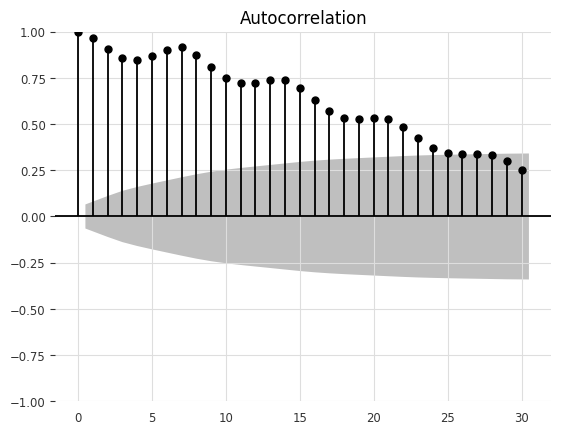

In [248]:
# Plot ACF to check for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
plot_acf(series.POSITIVE)
result = adfuller(mdf.POSITIVE.dropna())
print('p-value: ', result[1])

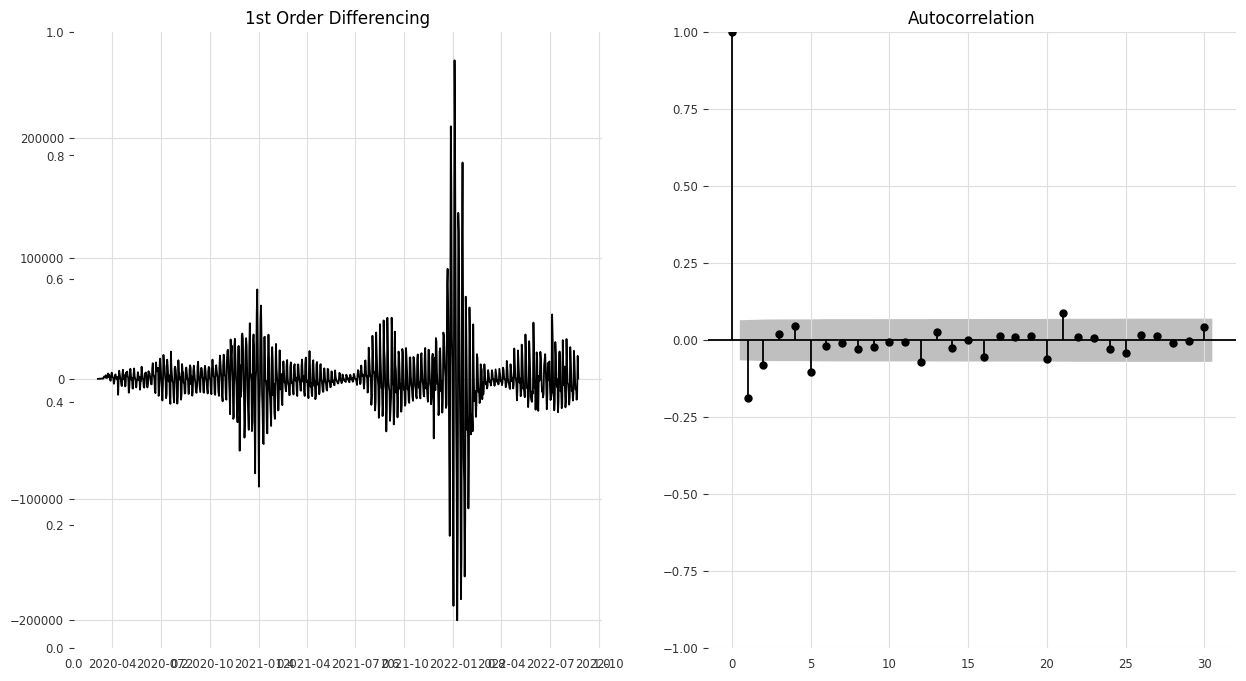

p-value:  2.0140827902190503e-17


In [252]:
#First order differencing
f, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0] = f.add_subplot(121)
axs[0].set_title('1st Order Differencing')
axs[0].plot(series.POSITIVE.diff())
#Plot PCAF and check it


plot_acf(mdf.POSITIVE.diff().dropna(), ax=axs[1])
plt.show()

#Test statistic
result = adfuller(mdf.POSITIVE.diff().dropna())
print('p-value: ', result[1])

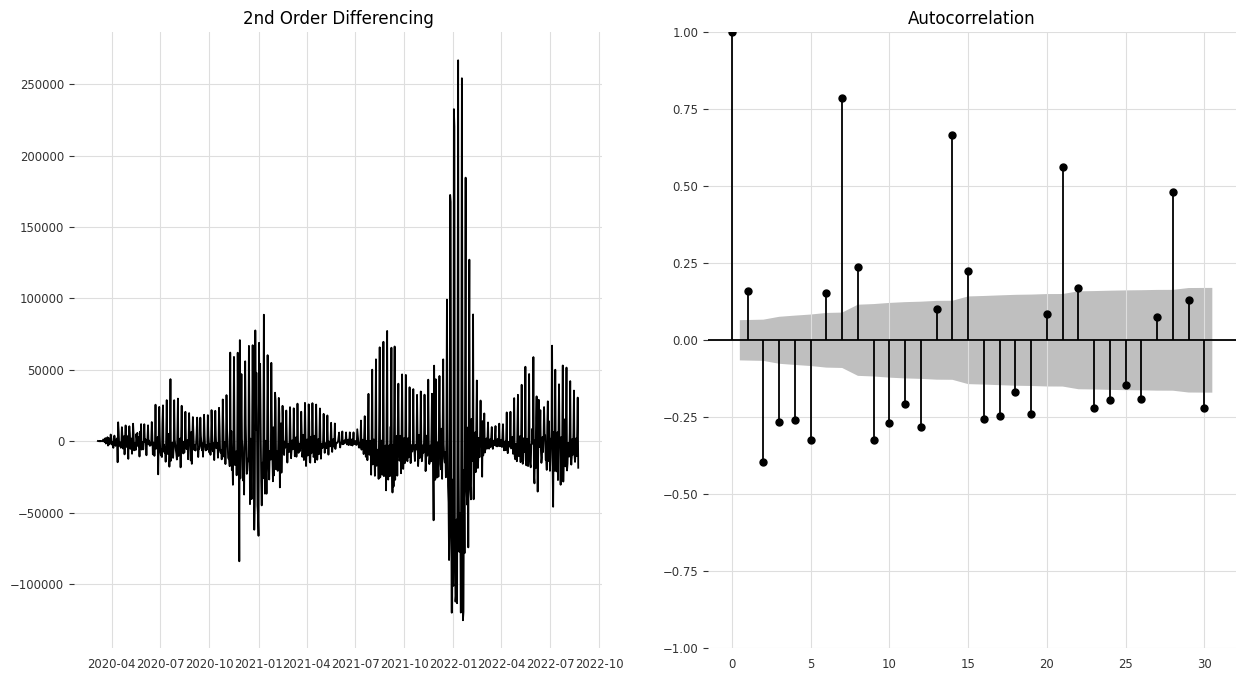

p-value:  4.1926212710635154e-10


In [256]:
#Second order differencing
f, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].set_title('2nd Order Differencing')
axs[0].plot(series.POSITIVE.diff().diff())


plot_acf(series.POSITIVE.diff().diff().dropna(), ax=axs[1])
plt.show()
result = adfuller(series.POSITIVE.diff().diff().dropna())
print('p-value: ', result[1])

# Checking for seasonality. mseas will be used as an input to models

In [257]:
# check for seasonality, via ACF

for m in range(2, 12):
    is_seasonal, mseas = check_seasonality(ts, m=m, alpha=ALPHA)
    if is_seasonal:
        break
    else:
        mseas = 12

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))
print(f'mseas = {mseas}')

seasonal? True
There is seasonality of order 7.
mseas = 7


728 training obs
181 testing obs


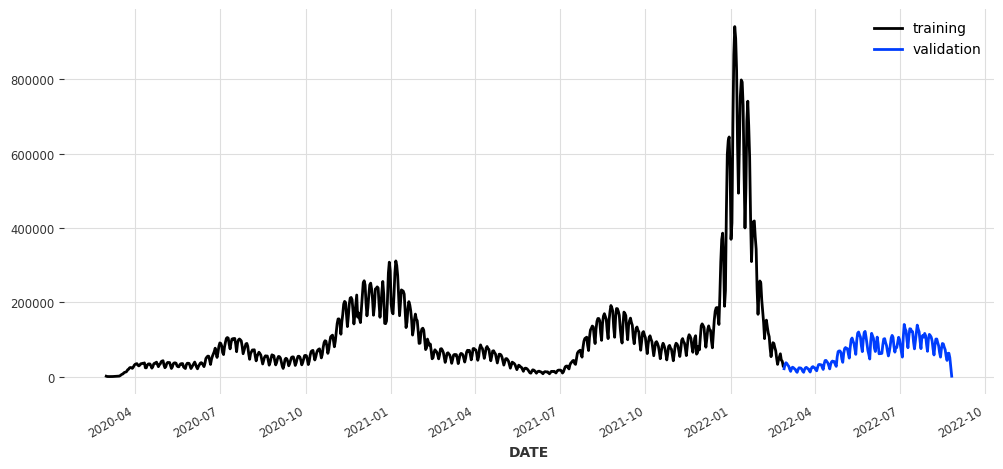

In [258]:
## split train and test data

# split position: if string, then interpret as Timestamp
# if int, then interpretation as index
# if loat, then interpretation as %split

# if isinstance(TRAIN, numbers.Number):
#     split_at = TRAIN
# else:
#     split_at = pd.Timestamp(TRAIN)
# train, val = ts.split_before(split_at)

from darts.utils import model_selection
train, val = model_selection.train_test_split(ts, test_size=0.20, axis=0, input_size=0, horizon=0, vertical_split_type='simple', lazy=False)
# train, val = model_selection.train_test_split(ts, test_size=0.33, axis=0, vertical_split_type='model-aware', horizon=3, input_size=3, lazy=False)

plt.figure(101, figsize=(12, 5))
train.plot(label='training')
val.plot(label='validation')
plt.legend();
print(f'{len(train)} training obs')
print(f'{len(val)} testing obs')

# Functions for pipeline. Building Models and Results

In [259]:
# compute accuracy metrics and processing time

def accuracy_metrics(act, forecast, resid, t_start):
    sr = resid.pd_series()
    sa = act.pd_series()
    n_act = len(act)
    res_mape = mape(act, forecast)
    res_mae = mae(act, forecast)
    res_r2 = r2_score(act, forecast)
    res_rmse = rmse(act, forecast)
    res_rmsle = rmsle(act, forecast)
    res_pe = sr / sa
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error

    res_time = time.perf_counter() - t_start
    
    res_mean = np.mean(sr)
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {"MAPE":res_mape,"RMSE":res_rmse, "-R squared":-res_r2, 
        "se": res_sefc, "time":res_time}
    return res_accuracy

In [260]:
# Chance to set mseas manually to check model performance. Comment out to use mseas from above
# mseas = 12

In [261]:
## fit the chosen forecaster model and compute predictions

def eval_model(model):
    t_start =  time.perf_counter()
    strmodel = str(model)[:30]
    print("beginning: " + strmodel)


    # fit the model and compute predictions
    n_val = len(val)
    res = model.fit(train)
    forecast = model.predict(n_val)


    # for naive forecast, concatenate seasonal fc with drift fc
    if model == m_naive:
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train)
            fc_seas = modelS.predict(len(val))
            forecast = fc_drift + fc_seas - train.last_value()


    resid = forecast - val
    res_accuracy = accuracy_metrics(val, forecast, resid, t_start)
    
    
    results = [forecast, res_accuracy]
    
    print("completed: " + strmodel + ":" + str(res_accuracy["time"]) + " sec")
    return results

In [262]:
# prepare Naive forecaster

m_naive = NaiveDrift()
print("model:", m_naive)

model: Naive drift model


In [263]:
# prepare Exponential Smoothing forecaster

# SET EXPONENTIAL SMOOTHING MODE:
exp_mode = 'add'
# exp_mode = 'mult'

# Do research here to understand more about using exponential smoothing forecaster when data is seasonal.
if is_seasonal:
    if exp_mode == 'add':
        m_expon = ExponentialSmoothing( trend=ModelMode.ADDITIVE, 
                                    damped=False, 
                                    seasonal=ModelMode.ADDITIVE, 
                                    seasonal_periods=mseas) 
    else:
        m_expon = ExponentialSmoothing( trend=ModelMode.MULTIPLICATIVE, 
                                    damped=False, 
                                    seasonal=ModelMode.MULTIPLICATIVE, 
                                    seasonal_periods=mseas) 
else:
    m_expon = ExponentialSmoothing()

print("model:", m_expon)

model: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=7


In [264]:
# prepare Prophet forecaster

m_prophet = Prophet()    #frequency=mseas)

# m_prophet = Prophet(add_seasonalities={'name': 'Mthly','seasonal_periods': 12, 'fourier_order': 1})

print("model:", m_prophet)

model: Prophet


In [265]:
# prepare ARIMA forecaster

y = np.asarray(ts.pd_series())
# get order of first differencing: the higher of KPSS and ADF test results
n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=4)
n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=4)
n_diff = max(n_adf, n_kpss)
# min_diff = min(n_adf, n_kpss)

# get order of seasonal differencing: the higher of OCSB and CH test results
n_ocsb = pmd.arima.OCSBTest(m=mseas).estimate_seasonal_differencing_term(y)
n_ch = pmd.arima.CHTest(m=mseas).estimate_seasonal_differencing_term(y)
ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)

# set up the ARIMA forecaster
m_arima = AutoARIMA(
    start_p=1, d=n_diff, start_q=1,
    max_p=4, max_d=n_diff, max_q=4,
    start_P=0, D=ns_diff, start_Q=0, m=max(4,mseas), seasonal=is_seasonal,
    max_P=3, max_D=1, max_Q=3,
    max_order=5,                       # p+q+p+Q <= max_order
    stationary=False, 
    information_criterion="bic", alpha=ALPHA, 
    test="kpss", seasonal_test="ocsb",
    stepwise=True, 
    suppress_warnings=True, error_action="trace", trace=TRACE, with_intercept="auto")
print("model:", m_arima)

model: Auto-ARIMA


In [266]:
# prepare Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
# search for best theta among 50 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    res_mape = mape(val, pred_theta)

    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta

m_theta = Theta(best_theta)   # best theta model among 100
print("model:", m_theta)

model: Theta(0.6868686868686869)


# Run the models

In [267]:
# laundry list of forecasters to run
# Comment each individual out to remove if won't run due to data length, etc.

models = [ 
    m_expon, 
    m_theta, 
    m_arima,
    m_naive, 
    m_prophet]



In [268]:
# call the forecasters one after the other

model_predictions = [eval_model(model) for model in models]

beginning: ExponentialSmoothing(trend=Mod
completed: ExponentialSmoothing(trend=Mod:0.22602159999951255 sec
beginning: Theta(0.6868686868686869)
completed: Theta(0.6868686868686869):0.04799300000013318 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:38.26442230000248 sec
beginning: Naive drift model
completed: Naive drift model:0.04058499999518972 sec
beginning: Prophet
completed: Prophet:0.45454639999661595 sec


In [281]:
# RUN the forecasters and tabulate their prediction accuracy and processing time

df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
df_acc.columns = [str(models[0])]

for i, m in enumerate(models):
    if i > 0: 
        df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        df.columns = [str(m)]
        df_acc = pd.concat([df_acc, df], axis=1)
    i +=1

pd.set_option("display.precision",3)
#df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)
display(df_acc)

,"ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=7",Theta(0.6868686868686869),Auto-ARIMA,Naive drift model,Prophet
MAPE,121.326,70.188,436.630,77.965,968.561
RMSE,40348.469,58443.779,238321.329,38054.243,345109.496
-R squared,0.323,1.776,45.157,0.177,95.789
se,2806.619,2896.001,10041.867,2409.750,3299.961
time,0.226,0.048,38.264,0.041,0.455


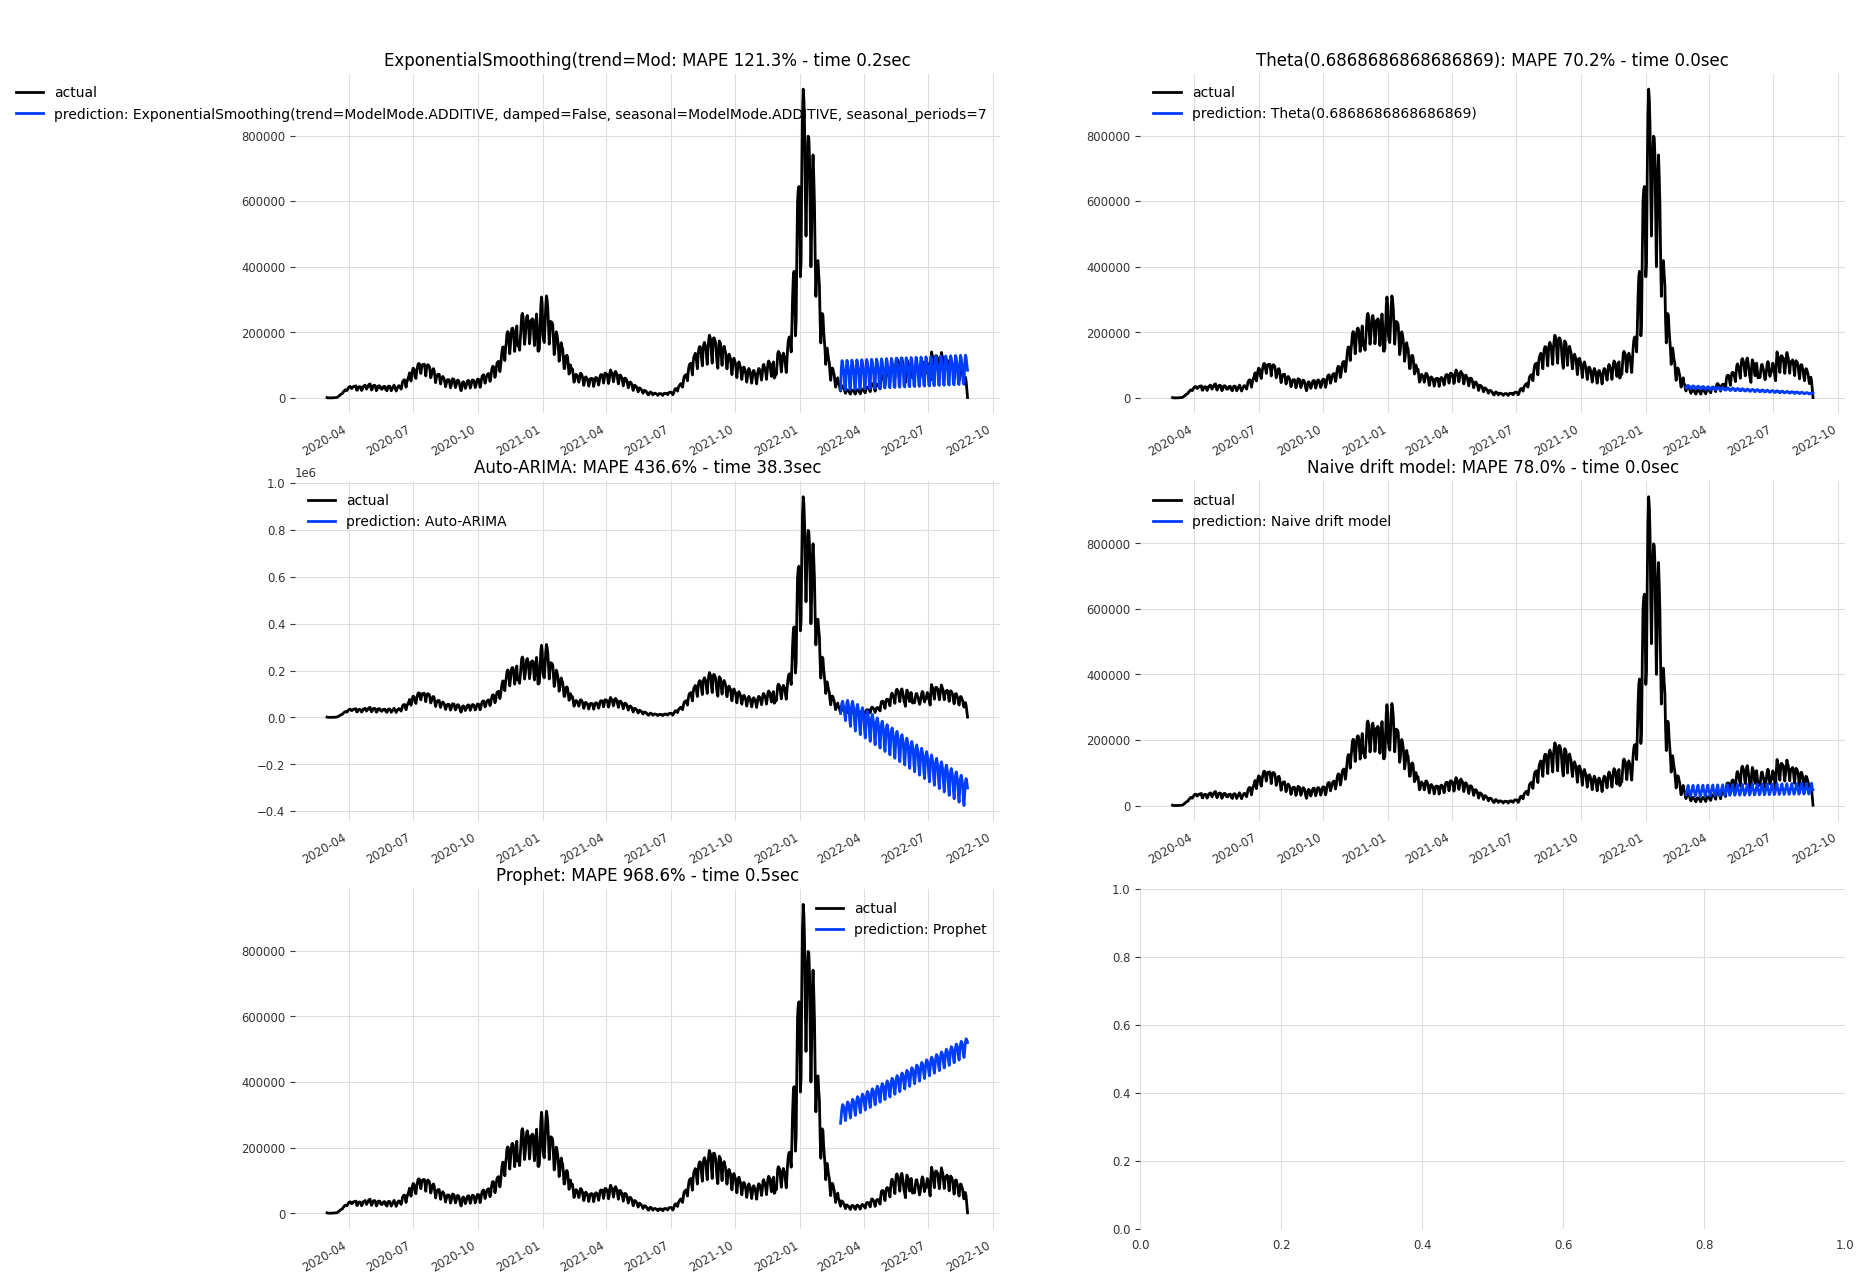

In [282]:
# plot the forecasts

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(models):
        ts.plot(label="actual", ax=ax[i])
        model_predictions[i][0].plot(label="prediction: "+str(m), ax=ax[i])
        
        mape_model =  model_predictions[i][1]["MAPE"]
        time_model =  model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + str(m)[:30] + ": MAPE {:.1f}%".format(mape_model) + " - time {:.1f}sec".format(time_model))

        ax[i].set_xlabel("")
        ax[i].legend()

In [283]:
act = val

resL = {}
resN = {} 
for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act
        sr = resid.pd_series() 

        resL[str(m)] = sm.stats.acorr_ljungbox(sr, lags=[5], return_df=False)[1][0]
        resN[str(m)] = normaltest(sr)[1]

        
print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
_ = [print(key,":",value) for key,value in resL.items()]

print("\ntest for normality of residuals: p-value > alpha?")
_ = [print(key,":",value) for key,value in resN.items()]




Ljung-Box test for white-noise residuals: p-value > alpha?
ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=7 : 1.050169045597216e-40
Theta(0.6868686868686869) : 2.315512648156351e-131
Auto-ARIMA : 1.0088421701647759e-163
Naive drift model : 1.8703905560652526e-131
Prophet : 5.480725199263715e-122

test for normality of residuals: p-value > alpha?
ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=7 : 0.00011158234845613057
Theta(0.6868686868686869) : 1.0171704970411212e-27
Auto-ARIMA : 1.5435053860046113e-20
Naive drift model : 1.1926602682987906e-17
Prophet : 1.0530329737657168e-09


In [284]:
# investigate the residuals in the validation dataset

act = val
df_desc = pd.DataFrame()

for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act
        resid = resid.pd_dataframe()

        df_desc = pd.concat([df_desc, resid.describe()], axis=1)

        #plot_residuals_analysis(resid);
        #plt.title(str(m))
        

In [285]:
# descriptive statistics of the forecast series
df_desc.columns = [str(m) for m in models]
print(df_desc)

       ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=7  \
count                                            181.000                                                              
mean                                           14458.920                                                              
std                                            37773.291                                                              
min                                           -56794.844                                                              
25%                                           -15322.592                                                              
50%                                            11257.720                                                              
75%                                            42964.314                                                              
max                                            9

# combine the individual models in an ensemble forecast:

In [354]:
### IMPORTANT NOTE FOR THE CELL:
# If you get an error that states: Unable to build any training samples of the target series and the corresponding covariate series; There is no time step for which all required lags are available and are not NaN values.
# Then try ADDITIVE in the ExponentialSmoothing model. If you need to adjust results, changing Exponential Smoothing to Multiplicative may help.

# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'
print(f'{len(train)} training obs')
print(f'{len(val)} testing obs')
print(f'Suggest starting n_train: {len(train)*.50}')

def ensemble_eval(train, val, models):
    t_start =  time.perf_counter()
    n_train =  364           # Here you will need to work with this number to train your data properly, similar to a test/train split
    n_val = len(val)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[    Theta(best_theta), 
                                                        Prophet(),
                                                        AutoARIMA(),
                                                        NaiveDrift(),
                                                        ExponentialSmoothing(
                                                                             trend=ModelMode.ADDITIVE, 
                                                                             damped=False, 
                                                                             seasonal=ModelMode.ADDITIVE, 
                                                                             seasonal_periods=mseas)]
                                ,regression_train_n_points=n_train)





    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - val


    res_accuracy = accuracy_metrics(val, forecast, resid, t_start)


    # plot the ensemble forecast
    ts.plot(label="actual")
    forecast.plot(label="Ensemble forecast")
    plt.title("MAPE = {:.2f}%".format(res_accuracy["MAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results

728 training obs
181 testing obs
Suggest starting n_train: 364.0


Ensemble of all 5 forecasters:


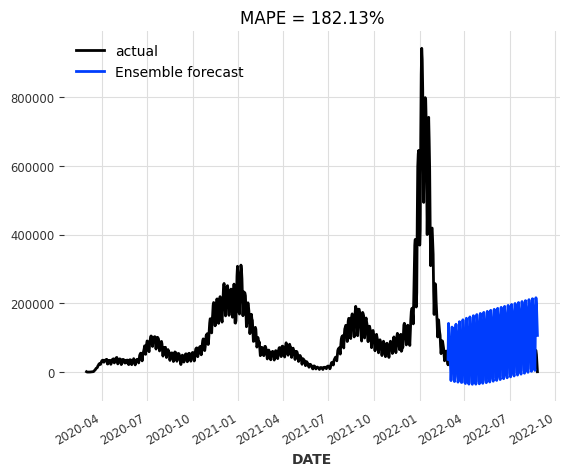

In [355]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["Expon", "Theta", "ARIMA", "Naive", "Prophet", "avg", "Ensemble"]
models2 = models

# run the ensemble forecast
print("Ensemble of all 5 forecasters:")
# print(f'ratio of missing values in training set: {missing_values_ratio(train)*100}%')
# print(f'ratio of missing values in training set: {missing_values_ratio(val)*100}%')
res_ensemble = ensemble_eval(train, val, models2)


In [356]:
# collect the accuracy metrics

df_acc2 = df_acc.copy()
df_acc2["avg"] = df_acc2.mean(axis=1)
df_acc2["Ensemble"] = pd.Series(res_ensemble[1])
df_acc2.columns = col_heads
df_acc2.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,Expon,Theta,ARIMA,Naive,Prophet,avg,Ensemble
MAPE,121.326126,70.187582,436.629538,77.965319,968.561429,334.933999,182.132430
RMSE,40348.468537,58443.778879,238321.329405,38054.243201,345109.496410,144055.463286,70007.512254
-R squared,0.323025,1.775815,45.157239,0.176847,95.789405,28.644466,2.982936
se,2806.618666,2896.000905,10041.866761,2409.749974,3299.960557,4290.839372,5004.740013
time,0.226022,0.047993,38.264422,0.040585,0.454546,7.806714,29.496368


In [357]:
#resid = res_ensemble[2]

resid = res_ensemble[0] - val
sr = resid.pd_series()
#plot_residuals_analysis(resid);
#plt.title("Ensemble forecast")

In [358]:
resL = sm.stats.acorr_ljungbox(sr, lags=[5], return_df=False)[1][0]
resN = normaltest(sr)[1]
   
print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
print(resL)

print("\ntest for normality of residuals: p-value > alpha?")
print(resN)


Ljung-Box test for white-noise residuals: p-value > alpha?
6.432128564035478e-37

test for normality of residuals: p-value > alpha?
1.3914256445411109e-11


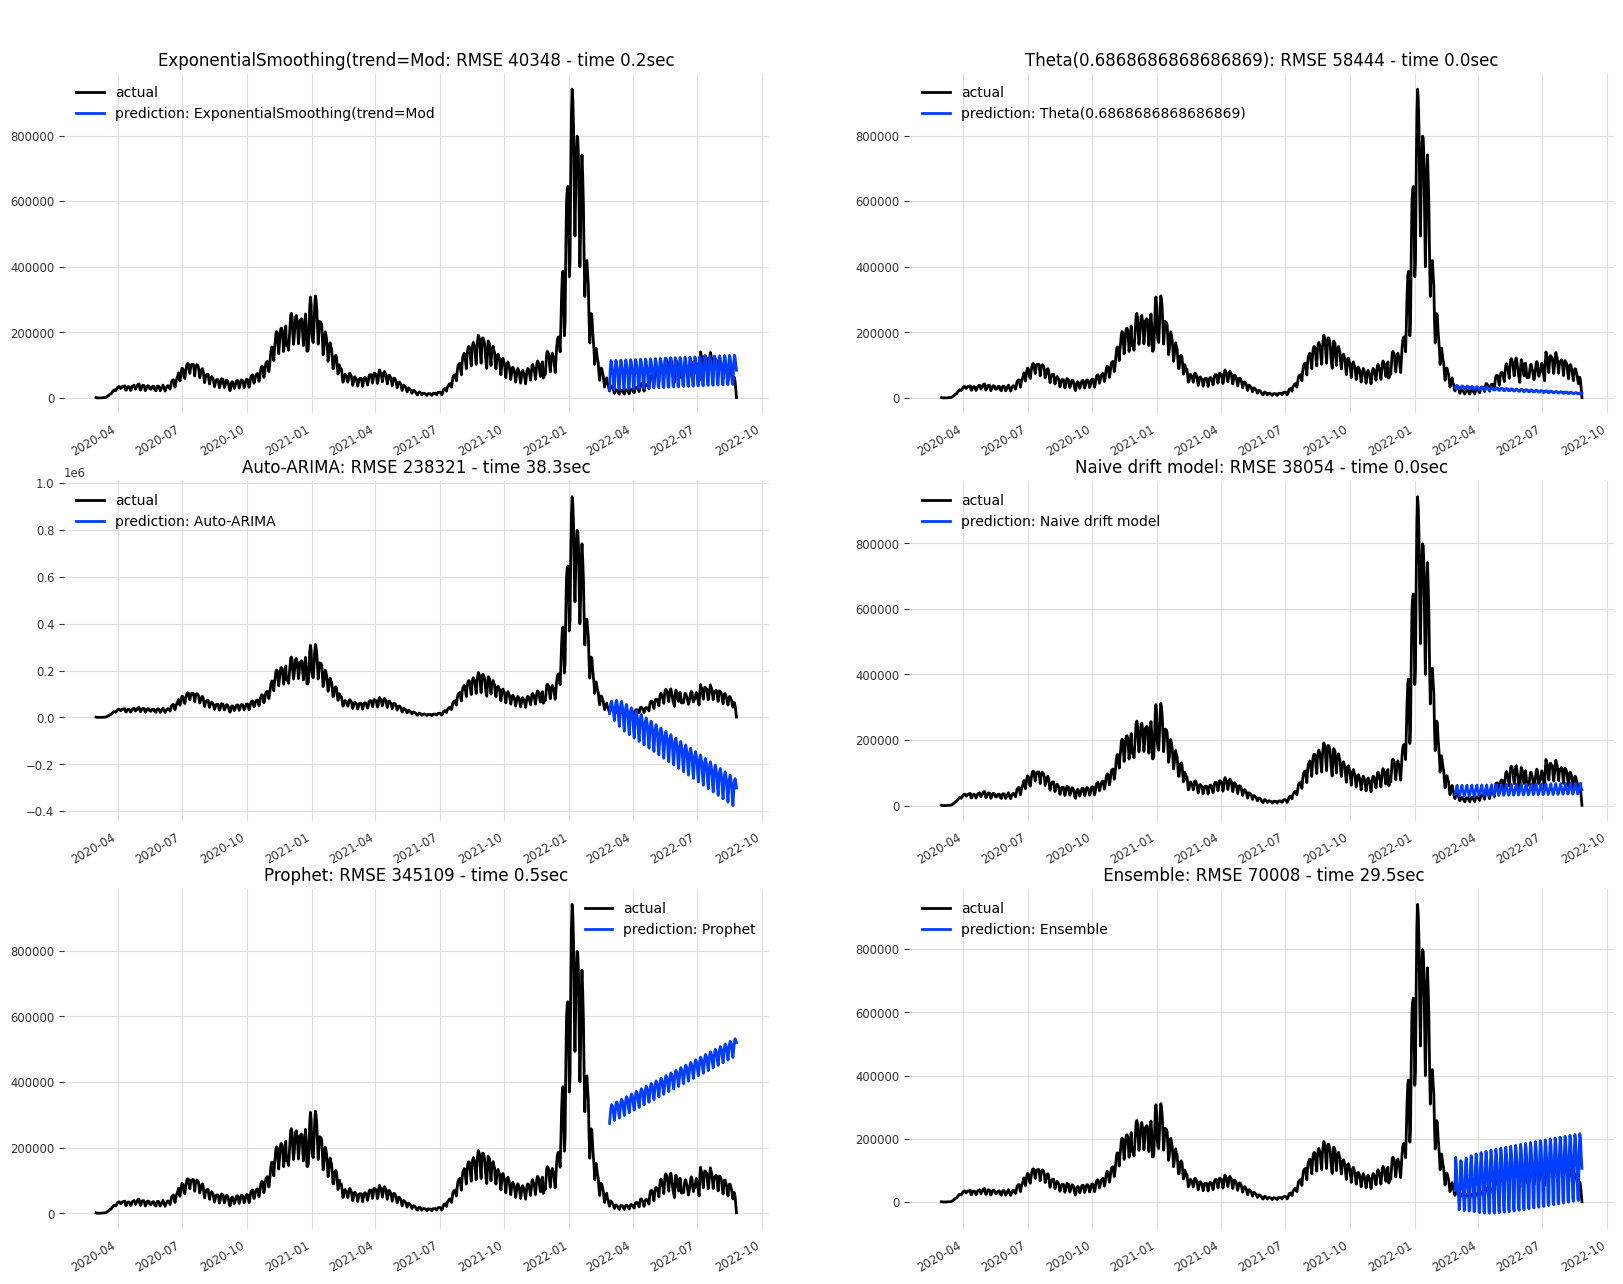

In [359]:
# plot the forecast scenario, and now include the ensemble

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(models):
        ts.plot(label="actual", ax=ax[i])
        model_predictions[i][0].plot(label="prediction: "+str(m)[:30], ax=ax[i])
        rmse_model =  model_predictions[i][1]["RMSE"]
        time_model =  model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + str(m)[:30] + ": RMSE {:.0f}".format(rmse_model) + " - time {:.1f}sec".format(time_model))
        ax[i].set_xlabel("")
        ax[i].legend()


# add the ensemble:
ts.plot(label="actual", ax=ax[i+1])
res_ensemble[0].plot(label="prediction: Ensemble", ax=ax[i+1])
rmse_model =  res_ensemble[1]["RMSE"]
time_model =  res_ensemble[1]["time"]
ax[i+1].set_title("\n\n Ensemble: RMSE {:.0f}".format(rmse_model) + " - time {:.1f}sec".format(time_model))
ax[i+1].set_xlabel("")
ax[i+1].legend();
